In [13]:
%matplotlib notebook
import pandas as pd
from numpy import array
import numpy as np
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


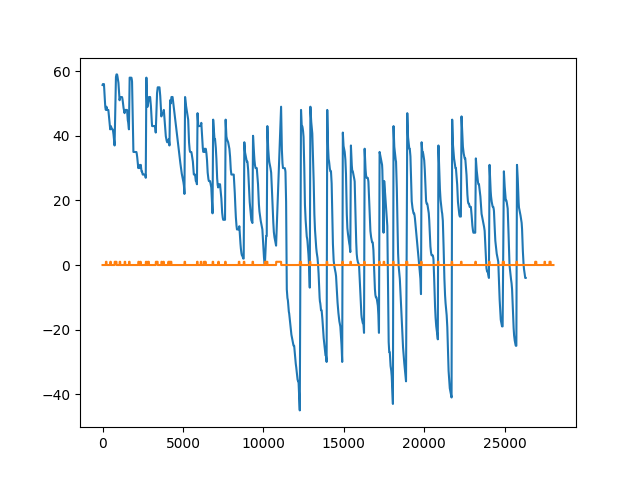

In [14]:
# Read Training data
train =pd.read_csv('Train.csv')

# Plot Training data
plt.plot(train.index, train[['Soil humidity 2','Irrigation field 2']])
plt.show()

In [2]:
# Extract pressures
pressure_list = train['Pressure (KPa)'].tolist()
pressure_list_without_nan = []
for i in range(len(pressure_list)):
    if (np.isnan(pressure_list[i])):
        pressure_list_without_nan.append(pressure_list_without_nan[i - 24*12])
    else:
        pressure_list_without_nan.append(pressure_list[i])

#Extract temperatures
temp_list = train['Air temperature (C)'].tolist()
temp_list_without_nan = []
for i in range(len(temp_list)):
    if (np.isnan(temp_list[i])):
        temp_list_without_nan.append(temp_list_without_nan[i - 24*12])
    else:
        temp_list_without_nan.append(temp_list[i])


In [3]:
def firstNanIndex(listfloats, k):
    for i, item in enumerate(listfloats):
        if i > k and math.isnan(item) == True:
            return i
        
def firstNonNan(listfloats, j):
    bol = False
    for i, item in enumerate(listfloats[j:]):
        if math.isnan(item) == False:
            bol = True
            return i+j, item
    if (bol == False):
        return len(listfloats) -1 , listfloats[len(listfloats)-1]
    
def cleanSerie(columnName):
    field = train[columnName].tolist()
    cleanedList = [x for x in field if (math.isnan(x) == False)]
    return cleanedList

                


In [20]:
# Clean the values: remove NaN
field1_without_Nan = cleanSerie('Soil humidity 1')

# Clean the values: remove last values
field1_without_Nan = field1_without_Nan[:-3]

field1 = train['Soil humidity 1'].tolist()
index1 = firstNanIndex(field1, 0)
field1 = field1[:index1+ 1153]

field2_without_Nan = cleanSerie('Soil humidity 2')
field2_without_Nan = field2_without_Nan[:-3]
field2 = train['Soil humidity 2'].tolist()
index2 = firstNanIndex(field2, 0)
field2 = field2[:index2+ 1747]

field3_without_Nan = cleanSerie('Soil humidity 3')
field3_without_Nan = field3_without_Nan[:-3]
field3 = train['Soil humidity 3'].tolist()
index3 = firstNanIndex(field3, 0)
field3 = field3[:index3+ 1153]

field4_without_Nan = cleanSerie('Soil humidity 4')
field4_without_Nan = field4_without_Nan[:-5]
field4 = train['Soil humidity 4'].tolist()
index4 = firstNanIndex(field4, 0)
field4 = field4[:index4+ 1729]


In [5]:
# Prepare the data. Returns X,Y:
# X: differential of air pressure, differential of air temperature, irrigation now
# Y: differential of soil humidity
def prepare_data(train,field_number, field_without_Nan, preds_horizon):
    target = train[['Pressure (KPa)','Air temperature (C)', 'Soil humidity ' + str(field_number),'Irrigation field ' +str(field_number)]][:len(field_without_Nan)]
    
    #Compute differential of soil humidity
    target['last'] = target[['Soil humidity ' + str(field_number)]].shift(1)
    target['diff'] = target['Soil humidity ' + str(field_number)] - target['last']
   
    #Compute differential of pressure
    target['pressure'] = target['Pressure (KPa)']   
    target['pressure_last'] = target[['pressure']].shift(1)
    target['diff_pressure'] = target['pressure'] - target['pressure_last']    
   
    #Compute differential of temperature
    target['temperature'] = target['Air temperature (C)']
    target['temperature_last'] = target[['temperature']].shift(1)
    target['diff_temperature'] = target['temperature'] - target['temperature_last']
       
    #Remove all the rest 
    del target['Air temperature (C)']
    del target['temperature_last']
    del target['pressure_last']   
    del target['temperature']
    del target['pressure']   
    del target['Pressure (KPa)']
   
  
    target['irrigation_now'] = train['Irrigation field ' +str(field_number)][:len(field_without_Nan)]
    X = target.dropna()
   
    
    del X['Soil humidity ' + str(field_number)]
    del X['last']
    
   
    # Y is the change of humidity (differential)
    Y = X['diff']
    
    del X['Irrigation field ' +str(field_number)]   
    del X['diff']

    return X, Y


In [6]:
# Train the model
def train_xgboost(data_X, data_Y, random_state=0):
    my_imputer = SimpleImputer()
    final_train = my_imputer.fit_transform(data_X)
    
    # split the data in training set and testing set (10%)
    train_X, test_X, train_y, test_y = train_test_split(final_train, data_Y, test_size=0.1, random_state=random_state)
    
    # Initialize model
    my_model = XGBRegressor(n_estimators=1500, learning_rate=0.1, random_state=random_state)
    
    # Train model. Evaluation metric = Root mean square Error
    my_model.fit(train_X, train_y, early_stopping_rounds=5,eval_metric=["rmse"], eval_set=[(test_X, test_y)], verbose=False)
    return my_model


In [7]:
def findStep(last_prediction, moisture_list, index):
    j = index
    while(np.isnan(moisture_list[j])):
        j =j+1
    step = (moisture_list[j] - last_prediction ) /(j-index)
    return step
    


In [34]:
# Get the prediction from the model
def get_Predictions(model, field_number, field_without_Nan, field, train_last_index, preds_horizon):
    moisture = field[len(field_without_Nan)-1:]
    irrigationFrame = train[['Irrigation field ' +str(field_number)]][len(field_without_Nan)-1:len(field_without_Nan)+preds_horizon]
    

    preds = []
    k=0
    index=-1
    bol = False
    for i in range(preds_horizon):
        index= index + 1

        temperature = temp_list_without_nan[train_last_index + index]
        temperature_last = temp_list_without_nan[train_last_index + index - 1]
        temperature_diff = temperature - temperature_last
        
        pressure = pressure_list_without_nan[train_last_index + index]
        pressure_last = pressure_list_without_nan[train_last_index + index - 1]
        pressure_diff = pressure - pressure_last
        
        irrigation = irrigationFrame.iloc[i+1]['Irrigation field ' + str(field_number)]
        if(np.isnan(irrigation)):
            irrigation =0

        #without irrigation
        if(irrigation == 0):
            bol = False
            x= np.array([pressure_diff, temperature_diff, irrigation])
            x = x[np.newaxis,...]
            print(x)
            # Perform the prediction
            prediction = model.predict(x) 
        if(irrigation == 1 and index ==0):
            x= np.array([pressure_diff, temperature_diff, irrigation])
            x = x[np.newaxis,...]
            prediction = model.predict(x) 
        if(irrigation == 1 and index > 0):
            if(bol == False):
                step =findStep(preds[-1], moisture, index)
                prediction = [step]
                bol = True
            else:
                prediction = [step]                
     
        if np.isnan(moisture[i]):
            preds.append(prediction[0]+ preds[-1])
            k=k+1
        else:
            preds.append(prediction[0]+ moisture[i])
            k=0
            
        k=k+1
    return preds

In [38]:
seed = 90973

# prepare the data
# data_X: differential of air pressure, differential of air temperature, irrigation now
# data_Y: differential of soil humidity
data_X, data_Y = prepare_data(train,1, field1_without_Nan, 1153)
print("data_X:")
display(data_X.head())
print("data_Y:")
display(data_Y.head())

# train the model
model1 = train_xgboost(data_X, data_Y, seed)

# Use the model to get predictions
preds1 = get_Predictions(model1,1, field1_without_Nan,field1, 8914, 1153)
display(*preds1)

data_X, data_Y = prepare_data(train,2, field2_without_Nan, 1747)

model2 = train_xgboost(data_X, data_Y, seed)
preds2 = get_Predictions(model2,2, field2_without_Nan,field2, 26301, 1747)

data_X, data_Y = prepare_data(train,3, field3_without_Nan, 1153)
model3 = train_xgboost(data_X, data_Y, seed)
preds3 = get_Predictions(model3,3, field3_without_Nan,field3, 16083, 1153)

data_X, data_Y = prepare_data(train,4, field4_without_Nan, 1729)
model4 = train_xgboost(data_X, data_Y, seed)
preds4 = get_Predictions(model4,4, field4_without_Nan,field4, 26301, 1729)



data_X:


,diff_pressure,diff_temperature,irrigation_now
1,0.00,-0.03,0.0
2,0.01,-0.02,0.0
3,0.00,0.07,0.0
4,0.00,0.07,0.0
5,0.00,0.06,0.0


data_Y:


1   -0.03
2   -0.03
3   -0.02
4   -0.03
5   -0.03
Name: diff, dtype: float64

[[ 0.    0.99  0.  ]]
[[ 0.   -0.07  0.  ]]
[[-0.01 -0.06  0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.04  0.  ]]
[[-0.01 -0.04  0.  ]]
[[-0.01  0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[-0.01 -0.03  0.  ]]
[[-0.01 -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.02  0.  ]]
[[-0.01  0.02  0.  ]]
[[ 0.    0.02  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.04  0.  ]]
[[-0.01 -0.03  0.  ]]
[[-0.01 -0.04  0.  ]]
[[ 0.    0.03  0.  ]]
[[-0.01  0.03  0.  ]]
[[ 0.    0.03  0.  ]]
[[-0.01 -0.01  0.  ]]
[[ 0.  0.  0.]]
[[-0.01  0.    0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.02  0.  ]]
[[-0.01 -0.1   0.  ]]
[[-0.01 -0.09  0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.01  0.  ]]
[[-0.01 -0.01  0.  ]]
[[-0.01 -0.02  0.  ]]
[[-0.01 -0.05  0.  ]]
[[ 0.   -0.05  0.  ]]
[[-0.01 -0.08  0.  ]]
[[ 0.   -0.07  0.  ]]
[[-0.01 -0.04  0.  ]]
[[-0.01 -0.04  0.  ]]


[[ 0.01 -0.1   0.  ]]
[[ 0.   -0.09  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.01 -0.03  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.   -0.06  0.  ]]
[[ 0.01 -0.06  0.  ]]
[[ 0.   -0.06  0.  ]]
[[ 0.01 -0.03  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.01 -0.03  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.01 -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.  0.  0.]]
[[ 0.    0.01  0.  ]]
[[ 0.01  0.01  0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.05  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.01 -0.12  0.  ]]
[[ 0.01 -0.12  0.  ]]
[[ 0.  -0.1  0. ]]
[[ 0.   -0.09  0.  ]]
[[ 0.   -0.11  0.  ]]
[[ 0.01 -0.1   0.  ]]
[[ 0.   -0.13  0.  ]]
[[ 0.   -0.14  0.  ]]
[[-0.01 -0.14  0.  ]]
[[ 0.   -0.14  0.  ]]
[[ 0.02 -0.13  0.  ]]
[[ 0.01 -0.12  0.  ]]
[[ 0.01 -0.12  0.  ]]
[[ 0.    0.99  0.  ]]
[[ 0.   -0.07  0.  ]]
[[-0.01 -0.06  0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.04  0.  ]]
[[-0.01 -0.04  0.  ]]
[[-0.01  0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[-0.01 -0.03  0.  ]]
[[-0.01 -

[[ 0.  -0.4  0. ]]
[[ 0.  -0.4  0. ]]
[[ 0.    1.59  0.  ]]
[[ 0.    1.59  0.  ]]
[[ 0.01  0.42  0.  ]]
[[ 0.    0.42  0.  ]]
[[ 0.   -0.49  0.  ]]
[[ 0.   -0.49  0.  ]]
[[ 0.    0.85  0.  ]]
[[ 0.    0.86  0.  ]]
[[ 0.    0.66  0.  ]]
[[ 0.01  0.65  0.  ]]
[[ 0.   -1.06  0.  ]]
[[ 0.01 -1.06  0.  ]]
[[-0.01  0.34  0.  ]]
[[-0.01  0.34  0.  ]]
[[ 0.    0.35  0.  ]]
[[ 0.    0.35  0.  ]]
[[ 0.    0.57  0.  ]]
[[-0.01  0.57  0.  ]]
[[-0.01  0.53  0.  ]]
[[-0.01  0.54  0.  ]]
[[ 0.01 -0.18  0.  ]]
[[ 0.   -0.19  0.  ]]
[[-0.01 -0.07  0.  ]]
[[-0.01 -0.08  0.  ]]
[[-0.01  0.34  0.  ]]
[[-0.01  0.34  0.  ]]
[[-0.01 -0.44  0.  ]]
[[-0.01 -0.45  0.  ]]
[[ 0.   -0.53  0.  ]]
[[-0.01 -0.52  0.  ]]
[[-0.01 -0.44  0.  ]]
[[-0.01 -0.45  0.  ]]
[[ 0.   -0.81  0.  ]]
[[ 0.   -0.81  0.  ]]
[[-0.01 -0.4   0.  ]]
[[ 0.  -0.4  0. ]]
[[ 0.    0.83  0.  ]]
[[-0.01  0.84  0.  ]]
[[-0.01  0.43  0.  ]]
[[ 0.    0.43  0.  ]]
[[ 0.   0.3  0. ]]
[[-0.01  0.29  0.  ]]
[[-0.01 -0.41  0.  ]]
[[-0.02 -0.4   0.  ]]


39.628363065719604

39.609794549942016

39.588189833164215

39.566789739131927

39.554567806720733

39.535999290943145

39.514394574165344

39.489333086013794

39.473073832988739

39.451469116210937

39.429864399433136

39.411295883655548

39.39272736787796

39.374158852100372

39.355590336322784

39.337021820545196

39.315417103767395

39.28681688785553

39.26701890707016

39.248450391292572

39.229881875514984

39.208277158737182

39.186672441959381

39.167543702125549

39.139612727165222

39.12048398733139

39.098879270553589

39.086657338142395

39.065257244110107

39.04385715007782

39.025288634300232

39.00368391752243

38.985115401744842

38.963510684967041

38.941905968189239

38.920301251411438

38.90173273563385

38.880128018856048

38.858523302078247

38.836918585300445

38.815313868522644

38.796745352745056

38.775140635967254

38.756572120189666

38.734967403411865

38.713362686634063

38.685431711673736

38.666302971839905

38.654081039428711

38.641859107017517

38.623290591239929

38.604722075462341

38.586153559684753

38.567585043907165

38.549016528129577

38.527411811351776

38.510710589885711

38.494009368419647

38.481787436008453

38.469565503597259

38.450996987819671

38.432661287784576

38.4065465259552

38.380431764125824

38.338991396427154

38.303548746109009

38.260880641937256

38.218368582725525

38.198570601940155

38.1823113489151

38.260580478111905

38.33884960730871

38.417118736505515

38.49538786570232

38.573656994899125

38.65192612409593

38.730195253292734

38.808464382489539

38.886733511686344

38.965002640883149

39.043271770079954

39.121540899276759

39.199810028473564

39.278079157670369

39.356348286867174

39.434617416063979

39.512886545260784

39.591155674457589

39.669424803654394

39.747693932851199

39.825963062048004

39.904232191244809

39.982501320441614

40.060770449638419

40.139039578835224

40.217308708032029

40.295577837228834

40.373846966425639

40.452116095622443

40.530385224819248

40.608654354016053

40.686923483212858

40.765192612409663

40.843461741606468

40.921730870803273

41.000000000000078

40.957111299037933

40.914222598075867

40.871480941772461

40.818341076374054

40.767709851264954

40.724821150302887

40.682079493999481

40.63994300365448

40.592441380023956

40.57489550113678

40.557349622249603

40.540648400783539

40.523947179317474

40.481205523014069

40.438316822052002

40.395575165748596

40.372434020042419

40.361118018627167

40.338439643383026

40.320128858089447

40.277616798877716

40.235104739665985

40.216536223888397

40.198200523853302

40.170587182044983

40.142160177230835

40.091363728046417

40.041688919067383

40.018547773361206

39.995406627655029

39.94007283449173

39.88473904132843

39.854321002960205

39.823755919933319

39.791409730911255

39.759063541889191

39.712619721889496

39.666175901889801

39.614850401878357

39.56171053647995

39.518879175186157

39.485096395015717

39.442014932632446

39.398933470249176

39.349635601043701

39.300337731838226

39.250269114971161

39.201322138309479

39.159555017948151

39.117787897586823

39.100242018699646

39.076798737049103

39.055194020271301

39.0335893034935

38.990507841110229

38.947426378726959

38.906503975391388

38.865581572055817

38.829799115657806

38.784876108169556

38.743953704833984

38.703031301498413

38.662095129489899

38.621158957481384

38.586367189884186

38.563226044178009

38.516782224178314

38.463072419166565

38.421305298805237

38.37841659784317

38.33590042591095

38.294223189353943

38.259431421756744

38.220342755317688

38.167755961418152

38.115169167518616

38.083454132080078

38.051739096641541

38.021578431129456

37.991417765617371

37.963486790657043

37.938659131526947

37.888590514659882

37.838521897792816

37.795837223529816

37.764803171157837

37.743198454380035

37.726264417171478

37.683748245239258

37.642071008682251

37.588128685951233

37.553678512573242

37.536744475364685

37.515139758586884

37.490312099456787

37.477059125900269

37.457930386066437

37.438801646232605

37.421867609024048

37.400262892246246

37.378807067871094

37.357351243495941

37.335895419120789

37.314439594745636

37.291761219501495

37.268317937850952

37.2468621134758

37.225406289100647

37.207095503807068

37.182067215442657

37.162938475608826

37.143809735774994

37.122205018997192

37.105270981788635

37.086922287940979

37.068573594093323

37.050224900245667

37.03187620639801

37.013527512550354

36.988461375236511

36.968663394451141

36.952404141426086

36.930948317050934

36.909492492675781

36.891908705234528

36.874324917793274

36.856014132499695

36.837703347206116

36.820360124111176

36.803426086902618

36.785115301609039

36.760087013244629

36.739404916763306

36.718722820281982

36.698040723800659

36.676765382289886

36.655309557914734

36.633853733539581

36.609440743923187

36.587984919548035

36.565306544303894

36.542628169059753

36.525694131851196

36.508992910385132

36.490657210350037

36.473313987255096

36.456612765789032

36.439678728580475

36.42134302854538

36.403007328510284

36.384671628475189

36.366335928440094

36.347767412662506

36.329431712627411

36.310863196849823

36.292527496814728

36.27395898103714

36.255623281002045

36.237287580966949

36.218951880931854

36.200616180896759

36.182047665119171

36.163711965084076

36.151490032672882

36.135230779647827

36.118971526622772

36.106749594211578

36.08818107843399

36.069612562656403

36.052911341190338

36.036210119724274

36.019276082515717

36.002342045307159

35.985408008098602

35.968706786632538

35.950358092784882

35.932009398937225

35.906943261623383

35.888594567775726

35.874194860458374

35.85749363899231

35.840792417526245

35.78915548324585

35.770586967468262

35.74898225069046

35.727582156658173

35.715360224246979

35.696791708469391

35.675186991691589

35.650125503540039

35.633866250514984

35.612261533737183

35.590656816959381

35.572088301181793

35.553519785404205

35.534951269626617

35.51638275384903

35.497814238071442

35.47620952129364

35.447609305381775

35.427811324596405

35.409242808818817

35.390674293041229

35.369069576263428

35.347464859485626

35.328336119651794

35.300405144691467

35.281276404857635

35.259671688079834

35.24744975566864

35.226049661636353

35.204649567604065

35.186081051826477

35.164476335048676

35.145907819271088

35.124303102493286

35.102698385715485

35.081093668937683

35.062525153160095

35.040920436382294

35.019315719604492

34.997711002826691

34.976106286048889

34.957537770271301

34.9359330534935

34.917364537715912

34.89575982093811

34.874155104160309

34.846224129199982

34.82709538936615

34.814873456954956

34.802651524543762

34.784083008766174

34.765514492988586

34.746945977210999

34.728377461433411

34.709808945655823

34.688204228878021

34.671503007411957

34.654801785945892

34.642579853534698

34.630357921123505

34.611789405345917

34.593453705310822

34.567338943481445

34.541224181652069

34.4997838139534

34.464341163635254

34.421673059463501

34.37916100025177

34.3593630194664

34.343103766441345

34.323305785655975

34.306371748447418

34.289437711238861

34.271861672401428

34.254285633563995

34.234487652778625

34.218228399753571

34.183311462402344

34.159580945968628

34.139782965183258

34.123523712158203

34.110270738601685

34.091141998767853

34.072376191616058

34.053557455539703

34.034428715705872

34.01529997587204

33.996731460094452

33.978162944316864

33.959852159023285

33.941503465175629

33.921705484390259

33.905446231365204

33.868773460388184

33.832970440387726

33.813841700553894

33.794712960720062

33.767625331878662

33.740537703037262

33.721969187259674

33.703633487224579

33.685064971446991

33.666496455669403

33.629823684692383

33.589999318122864

33.547257661819458

33.504368960857391

33.622363836401036

33.74035871194468

33.858353587488324

33.976348463031968

34.094343338575612

34.212338214119256

34.330333089662901

34.448327965206545

34.566322840750189

34.684317716293833

34.802312591837477

34.920307467381122

35.038302342924766

35.15629721846841

35.274292094012054

35.392286969555698

35.510281845099342

35.628276720642987

35.746271596186631

35.864266471730275

35.982261347273919

36.100256222817563

36.218251098361208

36.336245973904852

36.454240849448496

36.57223572499214

36.690230600535784

36.808225476079429

36.926220351623073

37.044215227166717

37.162210102710361

37.280204978254005

37.398199853797649

37.516194729341294

37.634189604884938

37.752184480428582

37.870179355972226

37.98817423151587

38.106169107059515

38.224163982603159

38.342158858146803

38.460153733690447

38.578148609234091

38.696143484777735

38.81413836032138

38.932133235865024

39.050128111408668

39.168122986952312

39.286117862495956

39.404112738039601

39.522107613583245

39.640102489126889

39.758097364670533

39.876092240214177

39.994087115757821

40.112081991301466

40.23007686684511

40.348071742388754

40.466066617932398

40.584061493476042

40.702056369019687

40.820051244563331

40.938046120106975

41.056040995650619

41.174035871194263

41.292030746737908

41.410025622281552

41.528020497825196

41.64601537336884

41.764010248912484

41.882005124456128

41.999999999999773

41.960911333560944

41.908324539661407

41.855737745761871

41.824022710323334

41.792307674884796

41.762147009372711

41.731986343860626

41.704055368900299

41.679227709770203

41.629159092903137

41.579090476036072

41.536405801773071

41.505371749401093

41.483767032623291

41.466832995414734

41.424316823482513

41.382639586925507

41.328697264194489

41.294247090816498

41.277313053607941

41.255708336830139

41.230880677700043

41.217627704143524

41.198498964309692

41.179370224475861

41.162436187267303

41.140831470489502

41.119375646114349

41.097919821739197

41.076463997364044

41.055008172988892

41.032329797744751

41.008886516094208

40.987430691719055

40.965974867343903

40.947664082050323

40.922635793685913

40.903507053852081

40.88437831401825

40.862773597240448

40.845839560031891

40.827490866184235

40.809142172336578

40.790793478488922

40.772444784641266

40.75409609079361

40.729029953479767

40.709231972694397

40.692972719669342

40.671516895294189

40.650061070919037

40.632477283477783

40.61489349603653

40.59658271074295

40.578271925449371

40.560928702354431

40.543994665145874

40.525683879852295

40.500655591487885

40.479973495006561

40.459291398525238

40.438609302043915

40.417333960533142

40.39587813615799

40.374422311782837

40.350009322166443

40.32855349779129

40.30587512254715

40.283196747303009

40.266262710094452

40.249561488628387

40.231225788593292

40.213882565498352

40.197181344032288

40.18024730682373

40.161911606788635

40.14357590675354

40.125240206718445

40.10690450668335

40.088335990905762

40.070000290870667

40.051431775093079

40.033096075057983

40.014527559280396

39.9961918592453

39.977856159210205

39.95952045917511

39.941184759140015

39.922616243362427

39.904280543327332

39.892058610916138

39.875799357891083

39.859540104866028

39.847318172454834

39.828749656677246

39.810181140899658

39.793479919433594

39.776778697967529

39.759844660758972

39.742910623550415

39.725976586341858

39.709275364875793

39.690926671028137

39.672577977180481

39.647511839866638

39.629163146018982

39.61476343870163

39.598062217235565

39.581360995769501

39.529724061489105

39.511155545711517

39.489550828933716

39.468150734901428

39.455928802490234

39.437360286712646

39.415755569934845

39.390694081783295

39.37443482875824

39.352830111980438

39.331225395202637

39.312656879425049

39.294088363647461

39.275519847869873

39.256951332092285

39.238382816314697

39.216778099536896

39.188177883625031

39.168379902839661

39.149811387062073

39.131242871284485

39.109638154506683

39.088033437728882

39.06890469789505

39.040973722934723

39.021844983100891

39.00024026632309

38.988018333911896

38.966618239879608

38.945218145847321

38.926649630069733

38.905044913291931

38.886476397514343

38.864871680736542

38.84326696395874

38.821662247180939

38.803093731403351

38.781489014625549

38.759884297847748

38.738279581069946

38.716674864292145

38.698106348514557

38.676501631736755

38.657933115959167

38.636328399181366

38.614723682403564

38.586792707443237

38.567663967609406

38.555442035198212

38.543220102787018

38.52465158700943

38.506083071231842

38.487514555454254

38.468946039676666

38.450377523899078

38.428772807121277

38.412071585655212

38.395370364189148

38.383148431777954

38.37092649936676

38.352357983589172

38.334022283554077

38.307907521724701

38.281792759895325

38.240352392196655

38.20490974187851

38.162241637706757

38.119729578495026

38.099931597709656

38.083672344684601

38.063874363899231

38.046940326690674

38.030006289482117

38.012430250644684

37.994854211807251

37.975056231021881

37.958796977996826

37.923880040645599

37.900149524211884

37.880351543426514

37.864092290401459

37.85083931684494

37.831710577011108

37.812944769859314

37.794126033782959

37.774997293949127

37.755868554115295

37.737300038337708

37.71873152256012

37.700420737266541

37.682072043418884

37.662274062633514

37.646014809608459

37.609342038631439

37.573539018630981

37.55441027879715

37.535281538963318

37.508193910121918

37.481106281280518

37.46253776550293

37.444202065467834

37.425633549690247

37.407065033912659

37.370392262935638

37.330567896366119

37.287826240062714

37.244937539100647

37.20204883813858

37.159307181835175

37.106167316436768

37.055536091327667

37.012647390365601

36.969905734062195

36.927769243717194

36.88026762008667

36.862721741199493

36.845175862312317

36.828474640846252

36.811773419380188

36.769031763076782

36.726143062114716

36.68340140581131

36.660260260105133

36.64894425868988

36.62626588344574

36.607955098152161

36.56544303894043

36.522930979728699

36.504362463951111

36.486026763916016

36.458413422107697

36.429986417293549

36.379189968109131

36.329515159130096

36.30637401342392

36.283232867717743

36.227899074554443

36.172565281391144

36.142147243022919

36.111582159996033

36.079235970973969

36.046889781951904

36.000445961952209

35.954002141952515

35.902676641941071

35.849536776542664

35.806705415248871

35.77292263507843

35.72984117269516

35.68675971031189

35.637461841106415

35.58816397190094

35.538095355033875

35.489148378372192

35.447381258010864

35.405614137649536

35.38806825876236

35.364624977111816

35.343020260334015

35.321415543556213

35.278334081172943

35.235252618789673

35.194330215454102

35.15340781211853

35.11762535572052

35.072702348232269

35.031779944896698

34.990857541561127

34.949921369552612

34.908985197544098

34.874193429946899

34.851052284240723

34.804608464241028

34.750898659229279

34.70913153886795

34.666242837905884

34.623726665973663

34.582049429416656

34.547257661819458

34.508168995380402

34.455582201480865

34.402995407581329

34.371280372142792

34.339565336704254

34.309404671192169

34.279244005680084

34.251313030719757

34.226485371589661

34.176416754722595

34.12634813785553

34.083663463592529

34.052629411220551

34.031024694442749

34.014090657234192

33.971574485301971

33.929897248744965

33.875954926013947

33.841504752635956

33.824570715427399

33.802965998649597

33.778138339519501

33.764885365962982

33.74575662612915

33.726627886295319

33.709693849086761

33.68808913230896

33.666633307933807

33.645177483558655

33.623721659183502

33.60226583480835

33.579587459564209

33.556144177913666

33.534688353538513

33.513232529163361

33.494921743869781

33.469893455505371

33.450764715671539

33.431635975837708

33.410031259059906

33.393097221851349

33.374748528003693

33.356399834156036

33.33805114030838

33.319702446460724

33.301353752613068

33.276287615299225

33.256489634513855

33.2402303814888

33.218774557113647

33.197318732738495

33.179734945297241

33.162151157855988

33.143840372562408

33.125529587268829

33.108186364173889

33.091252326965332

33.072941541671753

33.047913253307343

33.027231156826019

33.006549060344696

32.985866963863373

32.9645916223526

32.943135797977448

32.921679973602295

32.897266983985901

32.875811159610748

32.853132784366608

32.830454409122467

32.81352037191391

32.796819150447845

32.77848345041275

32.76114022731781

32.744439005851746

32.727504968643188

32.709169268608093

32.690833568572998

32.672497868537903

32.654162168502808

32.63559365272522

32.617257952690125

32.598689436912537

32.580353736877441

32.561785221099854

32.543449521064758

32.525113821029663

32.506778120994568

32.488442420959473

32.469873905181885

32.45153820514679

32.439316272735596

32.423057019710541

32.406797766685486

32.394575834274292

32.376007318496704

32.357438802719116

32.340737581253052

32.324036359786987

32.30710232257843

32.290168285369873

32.273234248161316

32.256533026695251

32.238184332847595

32.219835638999939

32.194769501686096

32.17642080783844

32.162021100521088

32.145319879055023

32.128618657588959

32.076981723308563

32.058413207530975

32.036808490753174

32.015408396720886

32.003186464309692

31.984617948532104

31.963013231754303

31.937951743602753

31.921692490577698

31.900087773799896

31.878483057022095

31.859914541244507

31.841346025466919

31.822777509689331

31.804208993911743

31.785640478134155

31.764035761356354

31.735435545444489

31.715637564659119

31.697069048881531

31.678500533103943

31.656895816326141

31.63529109954834

31.616162359714508

31.588231384754181

31.569102644920349

31.547497928142548

31.535275995731354

31.513875901699066

31.492475807666779

31.473907291889191

31.452302575111389

31.433734059333801

31.412129342556

31.390524625778198

31.368919909000397

31.350351393222809

31.328746676445007

31.307141959667206

31.285537242889404

31.263932526111603

31.245364010334015

31.223759293556213

31.205190777778625

31.183586061000824

31.161981344223022

31.134050369262695

31.114921629428864

31.10269969701767

31.090477764606476

31.071909248828888

31.0533407330513

31.034772217273712

31.016203701496124

30.997635185718536

30.976030468940735

30.95932924747467

30.942628026008606

30.930406093597412

30.918184161186218

30.89961564540863

30.881279945373535

30.855165183544159

30.829050421714783

30.787610054016113

30.752167403697968

30.709499299526215

30.666987240314484

30.647189259529114

30.630930006504059

30.611132025718689

30.594197988510132

30.577263951301575

30.559687912464142

30.542111873626709

30.522313892841339

30.506054639816284

30.471137702465057

30.447407186031342

30.427609205245972

30.411349952220917

30.398096978664398

30.378968238830566

30.360202431678772

30.341383695602417

30.322254955768585

30.303126215934753

30.284557700157166

30.265989184379578

30.247678399085999

30.229329705238342

30.209531724452972

30.193272471427917

30.156599700450897

30.120796680450439

30.101667940616608

30.082539200782776

30.055451571941376

30.028363943099976

30.009795427322388

29.991459727287292

29.972891211509705

29.954322695732117

29.917649924755096

29.877825558185577

29.835083901882172

29.792195200920105

29.749306499958038

29.706564843654633

29.653424978256226

29.602793753147125

29.559905052185059

29.517163395881653

29.475026905536652

29.427525281906128

29.409979403018951

29.392433524131775

29.37573230266571

29.359031081199646

29.31628942489624

29.273400723934174

29.230659067630768

29.207517921924591

29.196201920509338

29.173523545265198

29.155212759971619

29.112700700759888

29.070188641548157

29.051620125770569

29.033284425735474

29.005671083927155

28.977244079113007

28.926447629928589

28.876772820949554

28.853631675243378

28.830490529537201

28.775156736373901

28.719822943210602

28.689404904842377

28.658839821815491

28.626493632793427

28.594147443771362

28.547703623771667

28.501259803771973

28.449934303760529

28.396794438362122

28.353963077068329

28.320180296897888

28.277098834514618

28.234017372131348

28.184719502925873

28.135421633720398

28.085353016853333

28.03640604019165

27.994638919830322

27.952871799468994

27.935325920581818

27.911882638931274

27.890277922153473

27.868673205375671

27.825591742992401

27.782510280609131

27.74158787727356

27.700665473937988

27.664883017539978

27.619960010051727

27.579037606716156

27.538115203380585

27.49717903137207

27.456242859363556

27.421451091766357

27.398309946060181

27.351866126060486

27.298156321048737

27.256389200687408

27.213500499725342

27.170984327793121

27.129307091236115

27.094515323638916

27.05542665719986

27.002839863300323

26.950253069400787

26.91853803396225

26.886822998523712

26.856662333011627

26.826501667499542

26.798570692539215

26.773743033409119

26.723674416542053

26.673605799674988

26.630921125411987

26.599887073040009

26.578282356262207

26.56134831905365

26.518832147121429

26.477154910564423

26.423212587833405

26.388762414455414

26.371828377246857

26.350223660469055

26.325396001338959

26.31214302778244

26.293014287948608

26.273885548114777

26.256951510906219

26.235346794128418

26.213890969753265

26.192435145378113

26.17097932100296

26.149523496627808

26.126845121383667

26.103401839733124

26.081946015357971

26.060490190982819

26.04217940568924

26.017151117324829

26.557228114153887

27.097305110982944

27.637382107812002

28.177459104641059

28.717536101470117

29.257613098299174

29.797690095128232

30.337767091957289

30.877844088786347

31.417921085615404

31.957998082444462

32.498075079273519

33.038152076102577

33.578229072931634

34.118306069760692

34.658383066589749

35.198460063418807

35.738537060247864

36.278614057076922

36.81869105390598

37.358768050735037

37.898845047564095

38.438922044393152

38.97899904122221

39.519076038051267

40.059153034880325

40.599230031709382

41.13930702853844

41.679384025367497

42.219461022196555

42.759538019025612

43.29961501585467

43.839692012683727

44.379769009512785

44.919846006341842

45.4599230031709

45.999999999999957

45.983065962791443

45.964730262756348

45.946394562721252

45.928058862686157

45.909723162651062

45.891154646873474

45.872818946838379

45.854250431060791

45.835914731025696

45.817346215248108

45.799010515213013

45.780674815177917

45.762339115142822

45.744003415107727

45.725434899330139

45.707099199295044

45.69487726688385

45.678618013858795

45.66235876083374

45.650136828422546

45.631568312644958

45.612999796867371

45.596298575401306

45.579597353935242

45.562663316726685

45.545729279518127

45.52879524230957

45.512094020843506

45.49374532699585

45.475396633148193

45.450330495834351

45.431981801986694

45.417582094669342

45.400880873203278

45.384179651737213

45.332542717456818

[[-0.08  0.99  0.  ]]
[[ 0.    0.44  0.  ]]
[[ 0.01  0.45  0.  ]]
[[ 0.01  0.65  0.  ]]
[[ 0.01  0.64  0.  ]]
[[ 0.    0.16  0.  ]]
[[ 0.    0.16  0.  ]]
[[ 0.01  0.78  0.  ]]
[[ 0.    0.78  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.    0.29  0.  ]]
[[ 0.    0.29  0.  ]]
[[ 0.    0.11  0.  ]]
[[ 0.01  0.11  0.  ]]
[[ 0.02  0.27  0.  ]]
[[ 0.02  0.27  0.  ]]
[[ 0.01  0.41  0.  ]]
[[ 0.01  0.41  0.  ]]
[[-0.01  0.11  0.  ]]
[[ 0.    0.11  0.  ]]
[[ 0.01  0.1   0.  ]]
[[ 0.01  0.1   0.  ]]
[[ 0.    0.28  0.  ]]
[[-0.01  0.28  0.  ]]
[[ 0.    0.14  0.  ]]
[[ 0.    0.14  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.01  0.19  0.  ]]
[[ 0.    0.19  0.  ]]
[[ 0.01  0.24  0.  ]]
[[ 0.01  0.25  0.  ]]
[[ 0.    0.07  0.  ]]
[[-0.01  0.07  0.  ]]
[[ 0.01  0.22  0.  ]]
[[ 0.    0.21  0.  ]]
[[ 0.01  0.58  0.  ]]
[[ 0.01  0.58  0.  ]]
[[ 0.01  0.13  0.  ]]
[[ 0.01  0.13  0.  ]]
[[-0.01  0.71  0.  ]]
[[-0.01  0.72  0.  ]]
[[ 0.   -0.14  0.  ]]
[[ 0.   -0.13  0.  ]]
[[ 0.    0

[[ 0.01 -0.05  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.01 -0.06  0.  ]]
[[ 0.01 -0.06  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.01 -0.01  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[-0.02  0.01  0.  ]]
[[-0.01  0.01  0.  ]]
[[ 0.01  0.    0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.02 -0.05  0.  ]]
[[ 0.02 -0.06  0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.01 -0.03  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.01 -0.03  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.    0.01  0.  ]]
[[-0.01  0.02  0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[-0.01 -0.02  0.  ]]
[[ 0.   

[[ 0.   -0.45  0.  ]]
[[-0.01 -0.45  0.  ]]
[[-0.01 -0.22  0.  ]]
[[-0.02 -0.23  0.  ]]
[[ 0.   -0.46  0.  ]]
[[ 0.   -0.46  0.  ]]
[[-0.01 -0.3   0.  ]]
[[-0.01 -0.29  0.  ]]
[[ 0.01 -0.28  0.  ]]
[[ 0.   -0.29  0.  ]]
[[ 0.   -0.13  0.  ]]
[[ 0.   -0.12  0.  ]]
[[ 0.   -0.46  0.  ]]
[[-0.01 -0.47  0.  ]]
[[ 0.   -0.21  0.  ]]
[[ 0.   -0.22  0.  ]]
[[-0.01 -0.08  0.  ]]
[[-0.01 -0.07  0.  ]]
[[ 0.   -0.21  0.  ]]
[[-0.01 -0.2   0.  ]]
[[ 0.   -0.21  0.  ]]
[[ 0.   -0.21  0.  ]]
[[-0.01 -0.22  0.  ]]
[[ 0.   -0.21  0.  ]]
[[-0.01  0.11  0.  ]]
[[-0.01  0.11  0.  ]]
[[ 0.   -0.18  0.  ]]
[[ 0.   -0.18  0.  ]]
[[ 0.    0.03  0.  ]]
[[ 0.    0.04  0.  ]]
[[-0.01 -0.18  0.  ]]
[[ 0.   -0.17  0.  ]]
[[-0.01 -0.21  0.  ]]
[[ 0.  -0.2  0. ]]
[[ 0.  -0.2  0. ]]
[[-0.01 -0.21  0.  ]]
[[-0.01 -0.03  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.14  0.  ]]
[[-0.01 -0.14  0.  ]]
[[-0.01 -0.14  0.  ]]
[[ 0.   -0.15  0.  ]]
[[ 0.   -0.17  0.  ]]
[[-0.01 -0.17  0.  ]]
[[-0.01 -0.14  0.  ]]
[[ 0.   -0.14  0

[[ 0.    0.01  0.  ]]
[[ 0.    0.06  0.  ]]
[[ 0.01  0.06  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.    0.03  0.  ]]
[[ 0.    0.03  0.  ]]
[[ 0.    0.06  0.  ]]
[[ 0.01  0.06  0.  ]]
[[ 0.01  0.11  0.  ]]
[[ 0.   0.1  0. ]]
[[ 0.    0.26  0.  ]]
[[ 0.    0.27  0.  ]]
[[ 0.01  0.39  0.  ]]
[[ 0.01  0.38  0.  ]]
[[ 0.    0.44  0.  ]]
[[ 0.    0.44  0.  ]]
[[ 0.01  0.36  0.  ]]
[[ 0.01  0.35  0.  ]]
[[-0.08  0.99  0.  ]]
[[ 0.    0.44  0.  ]]
[[ 0.01  0.45  0.  ]]
[[ 0.01  0.65  0.  ]]
[[ 0.01  0.64  0.  ]]
[[ 0.    0.16  0.  ]]
[[ 0.    0.16  0.  ]]
[[ 0.01  0.78  0.  ]]
[[ 0.    0.78  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.    0.29  0.  ]]
[[ 0.    0.29  0.  ]]
[[ 0.    0.11  0.  ]]
[[ 0.01  0.11

[[ 0.    0.49  0.  ]]
[[ 0.    0.49  0.  ]]
[[ 0.    0.58  0.  ]]
[[ 0.01  0.58  0.  ]]
[[ 0.01  0.24  0.  ]]
[[ 0.    0.23  0.  ]]
[[ 0.   -0.19  0.  ]]
[[-0.01 -0.19  0.  ]]
[[ 0.01  0.39  0.  ]]
[[ 0.    0.39  0.  ]]
[[ 0.   -0.06  0.  ]]
[[ 0.   -0.06  0.  ]]
[[ 0.   0.4  0. ]]
[[ 0.    0.39  0.  ]]
[[ 0.01  0.58  0.  ]]
[[ 0.    0.58  0.  ]]
[[-0.01  0.02  0.  ]]
[[-0.01  0.03  0.  ]]
[[ 0.    0.53  0.  ]]
[[ 0.    0.52  0.  ]]
[[-0.01 -0.13  0.  ]]
[[ 0.   -0.13  0.  ]]
[[ 0.   -0.36  0.  ]]
[[ 0.   -0.37  0.  ]]
[[-0.01 -0.37  0.  ]]
[[-0.01 -0.37  0.  ]]
[[-0.01 -0.38  0.  ]]
[[-0.01 -0.37  0.  ]]
[[-0.01  0.5   0.  ]]
[[ 0.   0.5  0. ]]
[[-0.01 -0.53  0.  ]]
[[-0.01 -0.61  0.  ]]
[[-0.01 -0.62  0.  ]]
[[ 0.  -1.8  0. ]]
[[ 0.  -1.8  0. ]]
[[-0.01 -0.18  0.  ]]
[[-0.01 -0.18  0.  ]]
[[-0.01 -0.12  0.  ]]
[[-0.01 -0.11  0.  ]]
[[ 0.    0.46  0.  ]]
[[-0.01  0.46  0.  ]]
[[-0.01  0.37  0.  ]]
[[-0.01  0.38  0.  ]]
[[-0.01 -0.36  0.  ]]
[[ 0.   -0.35  0.  ]]
[[-0.01 -0.54  0.  ]]


[[ 0.   -0.02  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.08  0.  ]]
[[ 0.   -0.07  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.01  0.  ]]
[[-0.01 -0.01  0.  ]]
[[ 0.  0.  0.]]
[[-0.01  0.    0.  ]]
[[-0.01 -0.03  0.  ]]
[[-0.01 -0.03  0.  ]]
[[ 0.   -0.07  0.  ]]
[[ 0.   -0.08  0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.01  0.  ]]
[[-0.01 -0.01  0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.04  0.  ]]
[[-0.01 -0.03  0.  ]]
[[-0.01 -0.04  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[-0.01 -0.03  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.  0.  0.]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.01  0.  ]]
[[-0.01 -0.05  0.  ]]
[[-0.01 -0.05  0.  ]]
[[-0.01 -0.03  0.  ]]
[[-0.02 -0.02  0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.01  0.  ]]
[[-0.01 -0.05  0.  ]]
[[ 0.   -0.06  0.  ]]
[[ 0.   -0.02  0.  ]]
[[-0.01 -0.02  0.  ]]
[[ 0.    0.01  0. 

[[ 0.   -0.06  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.    0.03  0.  ]]
[[-0.01  0.04  0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.06  0.  ]]
[[-0.01 -0.06  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.    0.01  0.  ]]
[[-0.01  0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.03  0.  ]]
[[-0.01 -0.03  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.    0.01  0.  ]]
[[ 0.01  0.    0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.01  0.    0.  ]]
[[ 0.01  0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.    0.06  0.  ]]
[[ 0.01  0.06  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.0

[[-0.01 -0.06  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.    0.01  0.  ]]
[[-0.01  0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.03  0.  ]]
[[-0.01 -0.03  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.    0.01  0.  ]]
[[ 0.01  0.    0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.01  0.    0.  ]]
[[ 0.01  0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.    0.06  0.  ]]
[[ 0.01  0.06  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.01 -0.02  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.01 -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.    0.03  0.  ]]
[[ 0.    0.03  0.  ]]
[[ 0.    0.06  0.  ]]
[[ 0.01  0.06  0.  ]]
[[ 0.01  0.11  0.  ]]
[[ 0.   0.1  0. ]]
[[ 0.    0.26  0.  ]]
[[ 0.    0.27  0.  ]]
[[ 0.01  

[[-0.01  0.02  0.  ]]
[[ 0.    0.02  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[-0.01 -0.03  0.  ]]
[[-0.01 -0.04  0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.06  0.  ]]
[[ 0.   -0.05  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.    0.03  0.  ]]
[[-0.01  0.04  0.  ]]
[[-0.01  0.    0.  ]]
[[ 0.  0.  0.]]
[[ 0.   -0.06  0.  ]]
[[-0.01 -0.06  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.    0.01  0.  ]]
[[-0.01  0.01  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.02  0.  ]]
[[ 0.   -0.03  0.  ]]
[[-0.01 -0.03  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.  0.  0.]]
[[ 0.    0.01  0.  ]]
[[ 0.01  0.    0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.01  0.    0.  ]]
[[ 0.01  0.01  0.  ]]
[[ 0.    0.01  0.  ]]
[[ 0.    0.06  0.  ]]
[[ 0.01  0.06  0.  ]]
[[ 0.01 -0.04  0.  ]]
[[ 0.   -0.04  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0.  ]]
[[ 0.   -0.03  0. 

In [10]:
#Accumulate the results and write the submission file

total =[]
total.extend(preds1)
total.extend(preds2)
total.extend(preds3)
total.extend(preds4)

submission =pd.read_csv('SampleSubmission.csv')
submission['Values']= total
submission.to_csv('submission.csv', index=False)